In [19]:
import gymnasium as gym
import numpy as np
import torch
from gymnasium import spaces
from typing import List, Tuple, Dict, Any, Optional

In [20]:
class UNOGameEnv(gym.Env):

    TOTAL_CARDS = 108
    CARD_TYPES = 15
    COLORS = 4
    WILD_CARD_IDS = [25, 52, 79, 106]
    WILD_ACTION_IDS = [13, 28, 43, 58]
    WILD_DRAW_4_CARD_IDS = [26, 53, 80, 107]
    WILD_DRAW_4_ACTION_IDS = [14, 29, 44, 59]

    def __init__(self, n_agents: int, max_episode_length = 500):
        self.n_agents = n_agents
        self.max_episode_length = max_episode_length

        self.action_space = spaces.Discrete(self.COLORS * self.CARD_TYPES + 1) # 4 colors * 15 card types + 1 for drawing a card  

        self.observation_space = spaces.Tuple([
            spaces.Discrete(self.n_agents + 1), # Total number of players
            spaces.Discrete(self.n_agents), # Agent's position in the game
            spaces.Discrete(self.COLORS), # Game color
            spaces.Discrete(self.CARD_TYPES), # Last card type played
            spaces.Discrete(3, start=-1), # Game direction
            spaces.Discrete(self.TOTAL_CARDS + 1), # Number of cards in the deck
            spaces.Discrete(self.TOTAL_CARDS + 1), # Number of cards in the discard pile
            spaces.MultiDiscrete([self.TOTAL_CARDS + 1] * self.n_agents), # Number of cards in each player's hand
            spaces.MultiBinary(self.TOTAL_CARDS), # Agent's hand
        ])

        self.game_state = self._default_game_state()

    def reset(self) -> Tuple[int, int, int, int, int, int, int, List[int], List[int]]:
        self.game_state = self._default_game_state()
        return self._get_observation()

    def step(self, action_id: int) -> Tuple[Tuple[int, int, int, int, int, int, int, List[int], List[int]], float, bool, bool, Dict[str, Any]]:
        self.game_state["episode_step"] += 1
        reward = 0.1 # Default reward for making a move
        done = False
        truncated = self.game_state["episode_step"] >= self.max_episode_length
        invalid_action = False
        info = {}
        actor_id = self.game_state["current_player"]
        working_hand = self.game_state["hands"][actor_id]

        action_color_id, action_type = self._action_info(action_id)
        if action_type == 15:
            # Draw card
            if self._can_draw(1):
                working_hand[self.draw_cards(1)] = 1
            else:
                reward = -1
                invalid_action = True
        elif action_type == 14:
            # Wild Draw 4
            found_wild_draw_4 = [card_id for card_id in self.WILD_DRAW_4_CARD_IDS if working_hand[card_id]]
            if len(found_wild_draw_4) > 0:
                card_id = np.random.choice(found_wild_draw_4)
                working_hand[card_id] = 0
                self.game_state["discard_pile"].append(card_id)
                self.game_state["game_color"] = action_color_id
                next_player = (self.game_state["current_player"] + self.game_state["game_direction"]) % self.n_agents
                self.game_state['hands'][next_player][self.draw_cards(4)] = 1
            else:
                reward = -1
                invalid_action = True
        elif action_type == 13:
            # Wild
            wild_card_ids = [25, 52, 79, 106]
            found_wild = [card_id for card_id in wild_card_ids if working_hand[card_id]]
            if len(found_wild) > 0:
                card_id = np.random.choice(found_wild)
                working_hand[card_id] = 0
                self.game_state["discard_pile"].append(card_id)
                self.game_state["game_color"] = action_color_id
            else:
                reward = -1
                invalid_action = True
        elif action_color_id == self.game_state["game_color"] or action_type == self.game_state["top_card_type"]:
            # Regular card
            card_ids = self._get_cards_indices(action_color_id, action_type)
            found_card = [card_id for card_id in card_ids if working_hand[card_id]]
            if len(found_card) > 0:
                card_id = np.random.choice(found_card)
                working_hand[card_id] = 0
                self.game_state["discard_pile"].append(card_id)
                self.game_state["game_color"] = action_color_id
                self.game_state["top_card_type"] = action_type
                if action_type == 12:
                    # Draw 2
                    next_player = (self.game_state["current_player"] + self.game_state["game_direction"]) % self.n_agents
                    self.game_state['hands'][next_player][self.draw_cards(2)] = 1
                elif action_type == 11:
                    # Reverse
                    self.game_state["game_direction"] *= -1 
                elif action_type == 10:
                    # Skip
                    self.game_state["current_player"] = (self.game_state["current_player"] + self.game_state["game_direction"]) % self.n_agents
            else:
                reward = -1
                invalid_action = True
        else:
            reward = -1
            invalid_action = True

        if invalid_action:
            return self._get_observation(), reward, done, truncated, {}
            
        if np.sum(working_hand) == 0:
            done = True
            reward = 1
            info["winner"] = actor_id
        
        self.game_state["current_player"] = (self.game_state["current_player"] + self.game_state["game_direction"]) % self.n_agents
        observation = self._get_observation()
        if truncated:
            done = True
            self.reset()
        return observation, reward, done, truncated, info
    

    def draw_cards(self, n: int) -> List[int]:
        if len(self.game_state["deck"]) + len(self.game_state["discard_pile"]) < n:
            ret = self.game_state["deck"] + self.game_state["discard_pile"]
            self.game_state["deck"] = []
            self.game_state["discard_pile"] = []
            return ret
        if len(self.game_state["deck"]) < n:
            self.game_state["deck"] += np.random.permutation(self.game_state["discard_pile"]).tolist()
            self.game_state["discard_pile"] = []
        ret = self.game_state["deck"][:n]
        self.game_state["deck"] = self.game_state["deck"][n:]
        return ret


    def _default_game_state(self):
        current_player = np.random.randint(self.n_agents)
        game_direction = -1 if np.random.rand() < 0.5 else 1
        deck = np.random.permutation(self.TOTAL_CARDS)

        hands = np.zeros((self.n_agents, self.TOTAL_CARDS), dtype=int)
        hand_indices = np.arange(self.n_agents * 7).reshape(self.n_agents, 7)
        hands[np.arange(self.n_agents)[:, None], deck[hand_indices]] = 1
        deck = deck[self.n_agents * 7:]
        deck = deck.tolist()

        discard_pile = [deck.pop()]
        game_color, top_card_type = self._card_info(discard_pile[-1])
        if top_card_type == 12: # Draw 2
            hands[current_player][deck[:2]] = 1
            deck = deck[2:]
        elif top_card_type == 13: # Wild
            game_color = np.random.randint(4)
        elif top_card_type == 14: # Wild Draw 4
            hands[current_player][deck[:4]] = 1
            deck = deck[4:]
            game_color = np.random.randint(4)
        return {
            "current_player": current_player,
            "game_direction": game_direction,
            "deck": deck,
            "discard_pile": discard_pile,
            "game_color": game_color,
            "top_card_type": top_card_type,
            "hands": hands,
            "episode_step": 0
        }
    
    def _get_observation(self) -> Tuple[int, int, int, int, int, int, int, List[int], List[int]]:
        return (
            self.n_agents,
            self.game_state["current_player"],
            self.game_state["game_color"],
            self.game_state["top_card_type"],
            self.game_state["game_direction"],
            len(self.game_state["deck"]),
            len(self.game_state["discard_pile"]),
            np.sum(self.game_state["hands"], axis=1).tolist(),
            self.game_state["hands"][self.game_state["current_player"]].tolist(),
        )
    
    def _get_available_actions(self) -> np.ndarray:
        working_hand = self.game_state["hands"][self.game_state["current_player"]]
        game_color = self.game_state["game_color"]
        top_card_type = self.game_state["top_card_type"]

        available_actions = np.zeros(self.action_space.n, dtype=int)
        available_actions[-1] = self._can_draw(1)  # Draw card action
        
        available_actions[self.WILD_ACTION_IDS] = np.any(working_hand[self.WILD_CARD_IDS])
        available_actions[self.WILD_DRAW_4_ACTION_IDS] = np.any(working_hand[self.WILD_DRAW_4_CARD_IDS])

        color_split = self._get_cards_indices(game_color, None)
        type_split = self._get_cards_indices(None, top_card_type)

        for card_id in set(color_split).union(set(type_split)):
            if working_hand[card_id]:
                color_id, card_type = self._card_info(card_id)
                available_actions[color_id * self.CARD_TYPES + card_type] = 1
        return available_actions


    def _can_draw(self, n: int) -> int:
        return len(self.game_state["deck"]) + len(self.game_state["discard_pile"]) >= n


    def _card_info(self, card_id: int) -> Tuple[int, int]:
        color_id = card_id // 27
        colorless_id = card_id % 27
        if colorless_id == 0:
            card_type = 0
        elif colorless_id < 25:
            card_type = (colorless_id + 1) // 2
        elif colorless_id == 25:
            card_type = 13
        elif colorless_id == 26:
            card_type = 14
        else:
            card_type = -1
        return color_id, card_type
        
    def _action_info(self, action_id: int) -> Tuple[int, int]:
        if action_id == 60: # Draw card
            return 4, 15
        return action_id // 15, action_id % 15

    def _get_cards_indices(self, color_id: Optional[int], card_type: Optional[int]) -> List[int]:
        if color_id is None and card_type is None:
            return list(range(108))
        if card_type is None:
            return list(range(color_id * 27, (color_id + 1) * 27))
        colorless_ids = []
        if card_type == 0:
            colorless_ids.append(0)
        elif card_type < 13:
            colorless_ids.append(2 * card_type - 1)
            colorless_ids.append(2 * card_type)
        elif card_type == 13:
            color_id = None
            colorless_ids.append(25)
        elif card_type == 14:
            color_id = None
            colorless_ids.append(26)
        color_ids = [color_id] if color_id is not None else list(range(4))
        return [color_id * 27 + colorless_id for color_id in color_ids for colorless_id in colorless_ids]
            
        

In [ ]:
def obs_to_tensors(obs_batch, device):
    # Assume n_agents is constant across the batch
    n_agents = obs_batch[0][0]

    current_player_list = []
    game_color_list = []
    top_card_type_list = []
    game_direction_list = []
    deck_count_list = []
    discard_count_list = []
    hands_count_list = []
    hand_list = []

    for obs in obs_batch:
        current_player_list.append(obs[1])
        game_color_list.append(obs[2])
        top_card_type_list.append(obs[3])
        game_direction_list.append(obs[4])
        deck_count_list.append(obs[5])
        discard_count_list.append(obs[6])
        hands_count_list.append(obs[7])
        hand_list.append(obs[8])

    tensors = (
        torch.tensor(current_player_list, dtype=torch.long, device=device).unsqueeze(1),  # [batch_size, 1]
        torch.tensor(game_color_list, dtype=torch.long, device=device).unsqueeze(1),      # [batch_size, 1]
        torch.tensor(top_card_type_list, dtype=torch.long, device=device).unsqueeze(1),   # [batch_size, 1]
        torch.tensor(game_direction_list, dtype=torch.float32, device=device).unsqueeze(1),  # [batch_size, 1]
        torch.tensor(deck_count_list, dtype=torch.float32, device=device).unsqueeze(1),   # [batch_size, 1]
        torch.tensor(discard_count_list, dtype=torch.float32, device=device).unsqueeze(1),# [batch_size, 1]
        torch.tensor(hands_count_list, dtype=torch.float32, device=device),     # [batch_size, n_agents]
        torch.tensor(hand_list, dtype=torch.float32, device=device),            # [batch_size, n_cards_total]
    )
    return n_agents, tensors

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def relative_position_encoding(current_player, n_agents):
    batch_size = current_player.size(0)
    agents = torch.arange(n_agents, device=current_player.device)

    # Expand agents to match batch size
    agents = agents.expand(batch_size, -1)  # [batch_size, n_agents]

    # Compute distances
    distances = (agents - current_player) % n_agents  # Circular distance
    theta = (distances.float() / n_agents) * 2 * np.pi  # [batch_size, n_agents]

    # Compute sine and cosine
    sin_theta = torch.sin(theta)
    cos_theta = torch.cos(theta)
    relative_positions = torch.stack((sin_theta, cos_theta), dim=-1)  # [batch_size, n_agents, 2]

    return relative_positions

def scale_card_count(card_count, max_card_count=108):
    return torch.log1p(card_count.float()) / torch.log1p(torch.tensor(float(max_card_count), device=card_count.device))


class FeatureExtractor(nn.Module):
    def __init__(self, n_cards_total, embed_dim):
        super(FeatureExtractor, self).__init__()
        self.embed_dim = embed_dim
        self.n_cards_total = n_cards_total

        # Embedding layers for categorical features
        self.color_embedding = nn.Embedding(4, embed_dim)  # Game color
        self.card_type_embedding = nn.Embedding(15, embed_dim)  # Played card type

        # Linear layers for continuous features
        self.direction_linear = nn.Linear(1, embed_dim)          # Game direction
        self.deck_linear = nn.Linear(1, embed_dim)               # Number of cards in the deck
        self.discard_linear = nn.Linear(1, embed_dim)            # Number of cards in the discard pile
        self.hand_linear = nn.Linear(n_cards_total, embed_dim)   # Agent's hand

        # Normalization layers
        self.direction_norm = nn.LayerNorm(embed_dim)
        self.deck_norm = nn.LayerNorm(embed_dim)
        self.discard_norm = nn.LayerNorm(embed_dim)
        self.hand_norm = nn.LayerNorm(embed_dim)
        self.color_norm = nn.LayerNorm(embed_dim)
        self.card_type_norm = nn.LayerNorm(embed_dim)
        
        self.position_linear = nn.Linear(2, embed_dim)           # Relative position encoding
        self.position_norm = nn.LayerNorm(embed_dim)
        self.cards_count_linear = nn.Linear(1, embed_dim)        # Number of cards in each player's hand
        self.cards_count_norm = nn.LayerNorm(embed_dim)


        self.agent_feature_linear = nn.Linear(embed_dim * 2, embed_dim)
        self.agent_feature_norm = nn.LayerNorm(embed_dim)

        self.attention_layer = nn.Linear(embed_dim, 1)           # Compute attention scores

        self.final_linear = nn.Linear(embed_dim * 2, embed_dim)
        self.final_norm = nn.LayerNorm(embed_dim)


    def forward(self, n_agents, obs):
        (current_position, game_color, top_card_type, game_direction,
         deck_count, discard_count, hands_count, hand) = obs

        batch_size = current_position.size(0)
        device = current_position.device

        # Static Features Processing
        # Game color embedding
        color_emb = self.color_embedding(game_color).squeeze(1)
        color_emb = F.relu(color_emb)
        color_emb = self.color_norm(color_emb)

        # Top card type embedding
        card_type_emb = self.card_type_embedding(top_card_type).squeeze(1)
        card_type_emb = F.relu(card_type_emb)
        card_type_emb = self.card_type_norm(card_type_emb)

        # Game direction
        direction = game_direction  # [batch_size, 1]
        direction_feat = self.direction_linear(direction)
        direction_feat = F.relu(direction_feat)
        direction_feat = self.direction_norm(direction_feat)

        # Deck count
        deck_count = scale_card_count(deck_count)  # Scaling
        deck_count = deck_count
        deck_feat = self.deck_linear(deck_count)
        deck_feat = F.relu(deck_feat)
        deck_feat = self.deck_norm(deck_feat)

        # Discard pile count
        discard_count = scale_card_count(discard_count)
        discard_count = discard_count
        discard_feat = self.discard_linear(discard_count)
        discard_feat = F.relu(discard_feat)
        discard_feat = self.discard_norm(discard_feat)

        # Agent's hand
        hand_feat = self.hand_linear(hand)
        hand_feat = F.relu(hand_feat)
        hand_feat = self.hand_norm(hand_feat)

        # Combine static features
        static_features = color_emb + card_type_emb + direction_feat + deck_feat + discard_feat + hand_feat

        # Variable Features Processing
        # Relative positions
        rel_positions = relative_position_encoding(current_position, n_agents)  # [batch_size, n_agents, 2]
        rel_positions = rel_positions.view(-1, 2)
        position_feat = self.position_linear(rel_positions)
        position_feat = F.relu(position_feat)
        position_feat = self.position_norm(position_feat)
        position_feat = position_feat.view(batch_size, n_agents, self.embed_dim)

        # Hands count
        hands_count = hands_count.view(-1, 1)
        hands_count = scale_card_count(hands_count)
        cards_count_feat = self.cards_count_linear(hands_count)
        cards_count_feat = F.relu(cards_count_feat)
        cards_count_feat = self.cards_count_norm(cards_count_feat)
        cards_count_feat = cards_count_feat.view(batch_size, n_agents, self.embed_dim)

        # Combine position and cards count features
        agent_features = torch.cat([position_feat, cards_count_feat], dim=-1)  # [batch_size, n_agents, 2*embed_dim]
        agent_features = self.agent_feature_linear(agent_features)
        agent_features = F.relu(agent_features)
        agent_features = self.agent_feature_norm(agent_features)  # [batch_size, n_agents, embed_dim]

        # Attention mechanism
        attention_scores = self.attention_layer(agent_features)  # [batch_size, n_agents, 1]
        attention_weights = F.softmax(attention_scores, dim=1)
        weighted_agent_features = (agent_features * attention_weights).sum(dim=1)  # [batch_size, embed_dim]

        # Combine static and variable features
        combined_features = torch.cat([static_features, weighted_agent_features], dim=-1)  # [batch_size, embed_dim * 2]

        # Final transformation
        combined_features = self.final_linear(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = self.final_norm(combined_features)

        return combined_features

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, feature_extractor, embed_dim, action_space):
        super(ActorCritic, self).__init__()
        self.feature_extractor = feature_extractor
        self.action_head = nn.Linear(embed_dim, action_space)
        self.value_head = nn.Linear(embed_dim, 1)

    def forward(self, n_agents, obs):
        features = self.feature_extractor(n_agents, obs)
        action_logits = self.action_head(features)
        state_values = self.value_head(features)
        return action_logits, state_values

In [ ]:
from torch.distributions import Categorical

class Agent:
    def __init__(self, actor_critic, optimizer, clip_param=0.2, gamma=0.99, lam=0.95, device='cpu'):
        self.actor_critic = actor_critic
        self.optimizer = optimizer
        self.clip_param = clip_param
        self.gamma = gamma
        self.lam = lam
        self.device = device

    def select_action(self, obs, available_actions=None, temperature=1):
        n_agents, obs_tensors = obs_to_tensors([obs], self.device)
        self.actor_critic.eval()
        with torch.no_grad():
            logits, value = self.actor_critic(n_agents, obs_tensors)
            if available_actions is not None:
                logits = logits.masked_fill(~available_actions.bool(), -1e10)
            logits /= temperature
            dist = Categorical(logits=logits)
            action = dist.sample()
        return action.item(), value.item(), dist.log_prob(action).item(), dist.entropy().item()
    
    def compute_gae(self, rewards, values, masks, next_value):
        advantages = []
        gae = 0
        values = values + [next_value]
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * values[step + 1] * masks[step] - values[step]
            gae = delta + self.gamma * self.lam * masks[step] * gae
            advantages.insert(0, gae)
        returns = [adv + val for adv, val in zip(advantages, values[:-1])]
        return advantages, returns
    
    def update(self, trajectories):
        states = []
        actions = []
        log_probs_old = []
        returns = []
        advantages = []

        for trajectory in trajectories:
            states += trajectory['states']
            actions += trajectory['actions']
            log_probs_old += trajectory['log_probs']
            returns += trajectory['returns']
            advantages += trajectory['advantages']
        
        self.actor_critic.train()

        n_agents, obs_tensors = obs_to_tensors(states, self.device)
        actions = torch.tensor(actions, device=self.device)
        old_log_probs = torch.tensor(log_probs_old, device=self.device)
        returns = torch.tensor(returns, device=self.device)
        advantages = torch.tensor(advantages, device=self.device)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        logits, values = self.actor_critic(n_agents, obs_tensors)
        values = values.squeeze(1)
        dist = Categorical(logits=logits)
        log_probs = dist.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()
        value_loss = F.mse_loss(values, returns)
        loss = policy_loss + 0.5 * value_loss - 0.01 * dist.entropy().mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = FeatureExtractor(n_cards_total=UNOGameEnv.TOTAL_CARDS, embed_dim=64).to(device)
actor_critic = ActorCritic(feature_extractor, embed_dim=64, action_space=61).to(device)
optimizer = optim.Adam(actor_critic.parameters(), lr=3e-4)
agent = Agent(actor_critic, optimizer, device=device)

In [ ]:
from tqdm import tqdm

def get_temperature(episode, max_episodes, initial_temp=1.0, final_temp=0.1):
    return initial_temp - (episode / max_episodes) * (initial_temp - final_temp)

def get_masking_strength(episode, max_episodes, initial_strength=1.0, final_strength=0.0):
    return initial_strength - (episode / max_episodes) * (initial_strength - final_strength)

num_episodes = 100
training_loop = tqdm(range(num_episodes), desc="Training")
loss_history = []
for episode in training_loop:
    env = UNOGameEnv(n_agents=np.random.randint(2, 10))
    max_temperature = get_temperature(episode, num_episodes, initial_temp=5, final_temp=0.2)
    temperatures = np.random.uniform(0.2, max_temperature, size=env.n_agents)
    obs = env.reset()
    done = False
    truncated = False

    trajectories = [ {'states': [], 'actions': [], 'log_probs': [], 'rewards': [], 'values': [], 'masks': [], 'returns': [], 'advantages': []} for _ in range(env.n_agents) ]

    while not (done or truncated):
        current_player = obs[1]
        temperature = temperatures[current_player]

        available_actions = env._get_available_actions()
        available_actions_tensor = torch.tensor(available_actions, device=device)

        action, value, log_prob, entropy = agent.select_action(
            obs, temperature=temperature,
            available_actions=available_actions_tensor
        )
        next_obs, reward, done, truncated, info = env.step(action)

        trajectory = trajectories[current_player]
        trajectory['states'].append(obs)
        trajectory['actions'].append(action)
        trajectory['log_probs'].append(log_prob)
        trajectory['rewards'].append(reward)
        trajectory['values'].append(value)
        trajectory['masks'].append(1 - done)

        obs = next_obs
    
    for i, trajectory in enumerate(trajectories):
        if len(trajectory['rewards']) == 0:
            continue  # Skip agents who didn't play
        next_value = 0  # Assuming terminal state has value 0
        advantages, returns = agent.compute_gae(
            trajectory['rewards'], trajectory['values'], trajectory['masks'], next_value
        )
        trajectory['advantages'] = advantages
        trajectory['returns'] = returns

    # Update policy using collected trajectories
    loss = agent.update(trajectories)
    game_length = sum(len(t['rewards']) for t in trajectories)
    last_reward = trajectories[current_player]['rewards'][-1] if len(trajectories[current_player]['rewards']) > 0 else 0
    last_action = trajectories[current_player]['actions'][-1] if len(trajectories[current_player]['actions']) > 0 else -1
    training_loop.set_postfix(loss=loss, game_length=game_length, last_reward=last_reward, last_action=last_action)
    loss_history.append(loss)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training: 100%|██████████| 100/100 [04:01<00:00,  2.42s/it, game_length=500, last_action=28, last_reward=-1, loss=0.564]


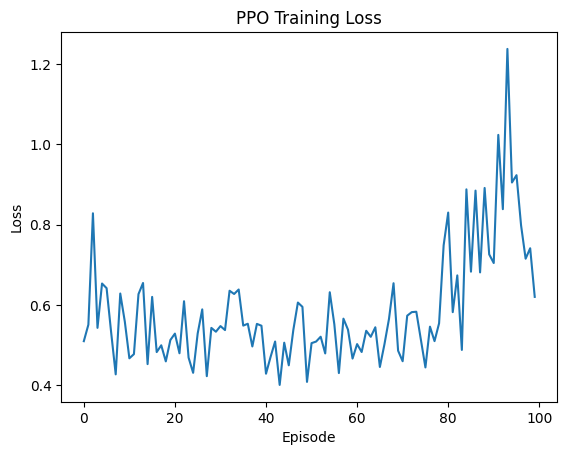

In [ ]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('PPO Training Loss')
plt.show()

In [ ]:
# Evaluate the model
num_episodes = 1000
temperatures = [0.1, 5, 125, 500]
winning_rates = [0 for _ in range(len(temperatures))]
eval_loop = tqdm(range(num_episodes), desc="Evaluating")
for episode in eval_loop:
    env = UNOGameEnv(n_agents=len(temperatures), max_episode_length=500)
    obs = env.reset()
    done = False
    truncated = False

    while not (done or truncated):
        current_player = obs[1]
        temperature = temperatures[current_player]
        available_actions = env._get_available_actions()
        available_actions_tensor = torch.tensor(available_actions, device=device)
        action, _, _, _ = agent.select_action(obs,
                                               temperature=temperature, 
                                               available_actions=available_actions_tensor
                                               )
        obs, _, done, truncated, info = env.step(action)

    if 'winner' in info:
        winning_rates[info['winner']] += 1

    eval_loop.set_postfix(winning_rates=winning_rates)

print(winning_rates)

Evaluating:   1%|          | 11/1000 [00:24<37:08,  2.25s/it, winning_rates=[0, 0, 0, 1]]


KeyboardInterrupt: 